<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#TICA" data-toc-modified-id="TICA-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>TICA</a></span></li></ul></li><li><span><a href="#CNN-Clustering" data-toc-modified-id="CNN-Clustering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CNN Clustering</a></span><ul class="toc-item"><li><span><a href="#Markov-State-Model" data-toc-modified-id="Markov-State-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Markov State Model</a></span></li><li><span><a href="#Open-Close-Transition" data-toc-modified-id="Open-Close-Transition-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Open-Close Transition</a></span></li></ul></li></ul></div>

In [1]:
import mdtraj as md
import matplotlib.pyplot as plt
import pyemma
import numpy as np
import scipy.linalg
from cnnclustering import cluster, hooks, plot
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
import matplotlib as mpl

Optional dependency module not found:  No module named 'networkx'
Optional dependency module not found:  No module named 'networkx'


In [2]:
mpl.rc_file('../matplotlibrc')

In [3]:
#### LOAD TRAJECTORY ###
t = md.load('../../VGLAPG_run1_compact_fit.xtc', top='../../VGLAPG_run0nowat.gro')
#
#### COMPUTE PHI AND PSI DIHEDRALS ###
#phi = md.compute_phi(t)
#psi = md.compute_psi(t)
#
#dihed_traj = np.concatenate((phi[1], psi[1]), axis=1)
#np.save('traj.npy', dihed_traj)

/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLY, VAL)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (LEU, GLY)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ALA, LEU)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PRO, ALA)
  war

In [4]:
dihed_traj = np.load('traj.npy')
np.save('VGLAPG_dihedrals.npy', dihed_traj[1000:])

In [5]:
d_ete_traj = md.compute_distances(t[1000::10], [[0, 75]])

In [6]:
print(t.top.atom(0), t.top.atom(75))

VAL67-N GLY72-OXT


## Load Data

We will work here with a 600 ns trajectory of the hexapeptide VGLAPG. We want to analyze the dynamics of its backbone and therefore use the backbone phi/psi dihedrals as our features of interest. The provided trajectory is a numpy array of shape (600001, 10). The first 5 columns are the phi dihedrals, the last 5 columns are the psi dihedrals. The timestep of the trajectory is 1 ps.

In [7]:
dihed_traj = np.load('VGLAPG_dihedrals.npy')
res_names = ['VAL1', 'GLY2', 'LEU3', 'ALA4', 'PRO5', 'GLY6']

In [8]:
dihed_traj.shape

(600001, 10)

We plot the ramachandran plots for the inner three aminoacids. Note that the ramachandran plot for the terminal aminoacids is not possible as the N-terminal aminoacid does not have a psi dihedral and the C-terminal aminoacid does not have a phi dihedral.

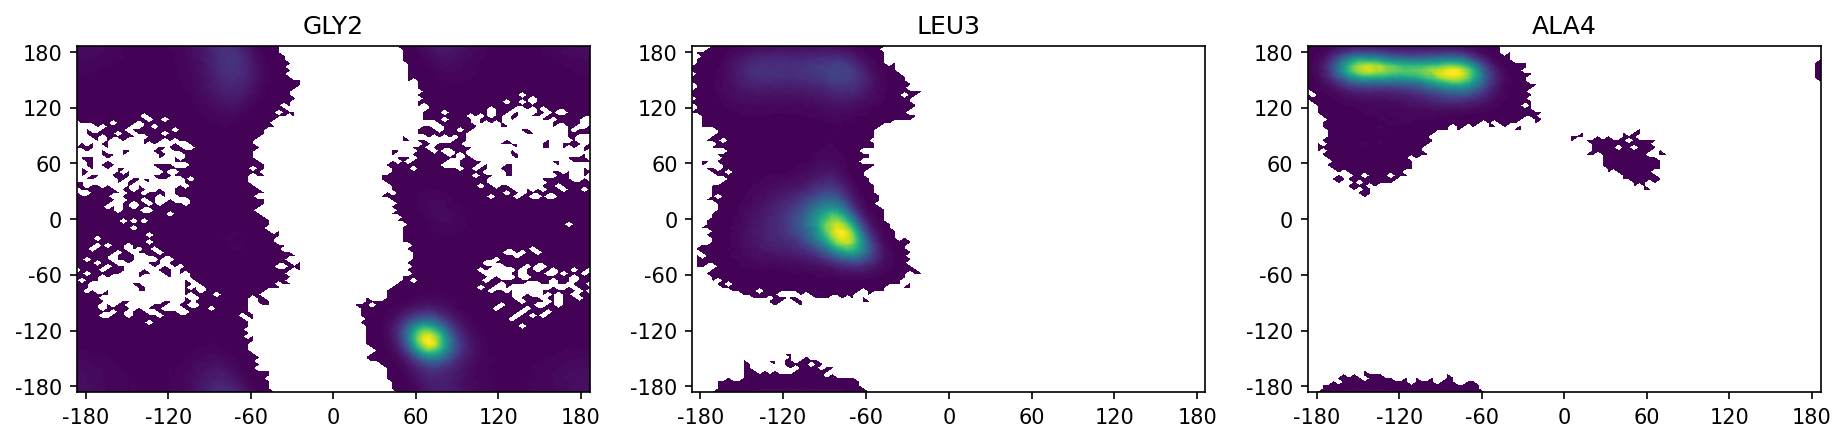

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for i in range(1, 4):
    pyemma.plots.plot_density(dihed_traj[:, i - 1], dihed_traj[:, i + 5], ax=axs[i - 1], cbar=False)
    axs[i - 1].set_title(res_names[i])
for ax in axs:
    ax.set_xticks(np.arange(-3, 3.1, 1))
    ax.set_xticklabels(np.arange(-180, 181, 60))
    ax.set_yticks(np.arange(-3, 3.1, 1))
    ax.set_yticklabels(np.arange(-180, 181, 60))

## TICA

We want to reduce our 10 dimensional data to 2 dimensions, which are easy to plot and a much simpler system. As we are not interested in rapidly changing dynamics and want to have a look at the slow dynamic processes of the backbone, we choose time-lagged independent component analysis (TICA) as our method of coordinate transformation.

In [10]:
tica = pyemma.coordinates.tica(dihed_traj, dim=2)

Text(0.5, 0, 'TIC #')

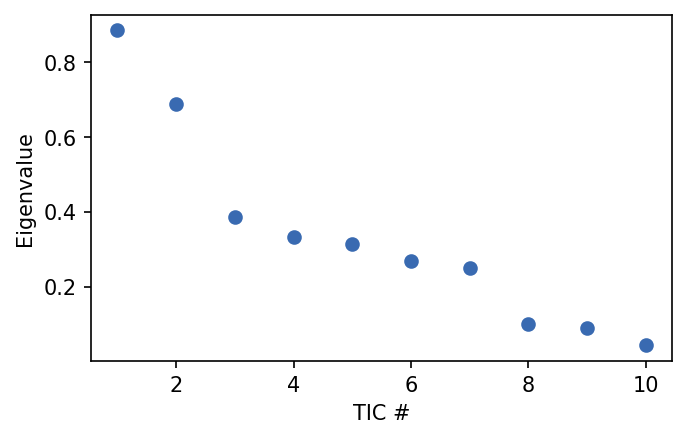

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 11, 1), tica.eigenvalues, 'o')
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('TIC #')

Text(0, 0.5, 'TIC 2')

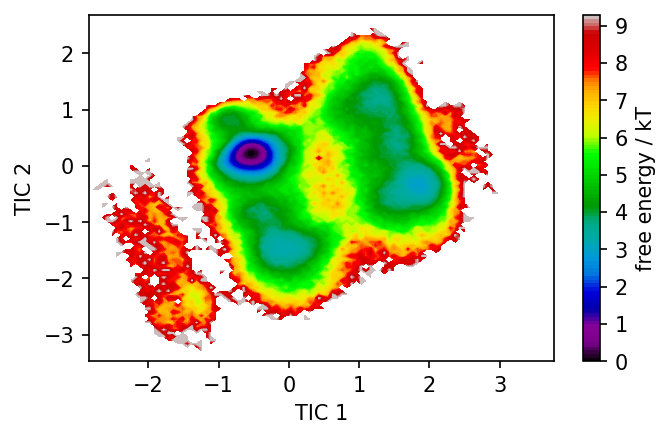

In [12]:
fig, ax = plt.subplots()
pyemma.plots.plot_free_energy(np.concatenate(tica.get_output())[:, 0], np.concatenate(tica.get_output())[:, 1], ax=ax)
ax.set_xlabel('TIC 1')
ax.set_ylabel('TIC 2')

## CNN Clustering

We want to create a Markov State Model on the 2D TICA data to study slow processes of the backbone dynamics. In the first step we need to discretize the 2D TICA space with a clustering method. Core-set MSMs based on density based clustering have proven to show good convergence, even with large biosystems, so we apply th density based CNN clustering algorithm. As the cluster fitting can get time-intensive for large datasets, we here reduce the dataset size by taking only every tenth point into account. This raises the timestep to 10 ps.

For CNN clustering we need to define the three parameters radius, neighbor cutoff and member cutoff. It is usually advisable to plot the pairwise distances of the dataset and choose a radius slightly shorter than the first maximum. We chose a radius of 0.2, a neighbor cutoff of 500 and a member cutoff of 10.

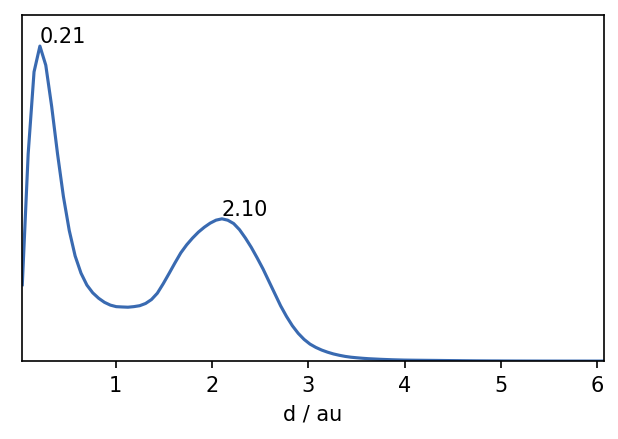

In [13]:
data = np.concatenate(tica.get_output())[::10]

distances = pairwise_distances(data[::10])
distance_rclustering = cluster.Clustering(distances, registered_recipe_key="distances")

fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances.flatten(), maxima=True, maxima_props={"order": 5})

In [14]:
#data = np.concatenate(tica.get_output())[::10]

clustering = cluster.Clustering(data)

# Pre-compute and sort neighbourhoods and choose the corresponding recipe
tree = KDTree(data)
neighbourhoods = tree.query_radius(
    data, r=0.2, return_distance=False
    )

for n in neighbourhoods:
    n.sort()

# Custom initialisation using a clustering builder
clustering_neighbourhoods_sorted = cluster.Clustering(
    neighbourhoods,
    preparation_hook=hooks.prepare_neighbourhoods,
    registered_recipe_key="sorted_neighbourhoods"
    )

In [15]:
# Use pre-computed neighbourhoods
clustering_neighbourhoods_sorted.fit(0.2, 550, 10)
clustering._labels = clustering_neighbourhoods_sorted._labels

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
60001     0.200     550       10        None      3         0.587     0.231     00:00:13.949
-----------------------------------------------------------------------------------------------



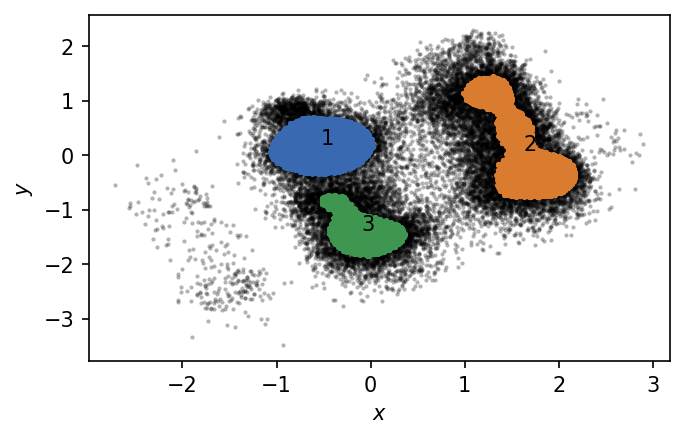

In [16]:
_ = clustering.evaluate()

We identified 3 clusters that we can plot in TICA space. Points outside the clusters are considered as noise.

## Markov State Model

To build the MSM we apply the PyEMMA package. Firstly, we have to adjust our discretized trajectories from the clustering, because noise in CNN clustering is indicated by the cluster number 0, while in PyEMMA it is -1. We adjust the dataset by substracting 1 from every cluster number.

In [17]:
dtrajs = [x - 1 for x in clustering.to_dtrajs()]

Next we need to choose a lag-time. We create an implied timescale plot to see at which lagtime the implied timescales converge.

estimating MaximumLikelihoodMSM:   0%|                                                                        …

05-11-21 12:15:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 12:15:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 12:15:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 12:15:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 12:15:31 pyemma.msm.estimat

/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 0 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))
/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 0 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))
/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 0 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))
/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/pyemma/util/discrete

05-11-21 12:15:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 0 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))


05-11-21 12:15:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 0 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))


05-11-21 12:15:31 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[3] WARNING  Changed user setting nits to the number of available timescales nits=2


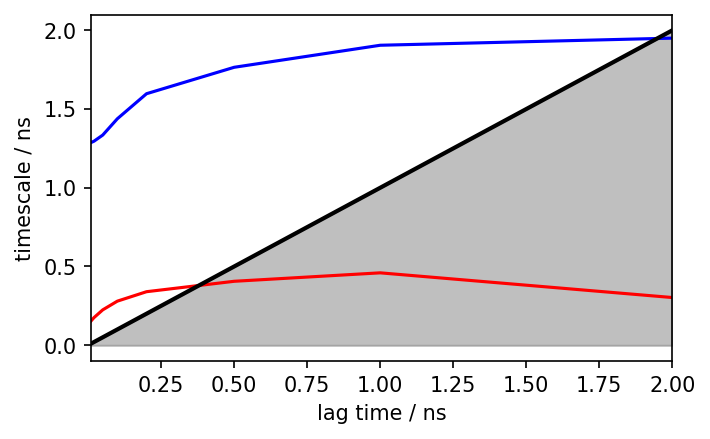

In [18]:
its = pyemma.msm.its(dtrajs, lags=[1, 2, 5, 10, 20, 50, 100, 200], nits=3)
pyemma.plots.plot_implied_timescales(its, ylog=False, dt=0.01, units='ns')

We see the implied timescales converge at a lag time of about 1 ns, which we take as the lagtime for our MSM.

In [19]:
MSM = pyemma.msm.estimate_markov_model(dtrajs, lag=100)

05-11-21 12:15:32 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 0 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))


We can analyze the MSM by plotting its eigenvectors.

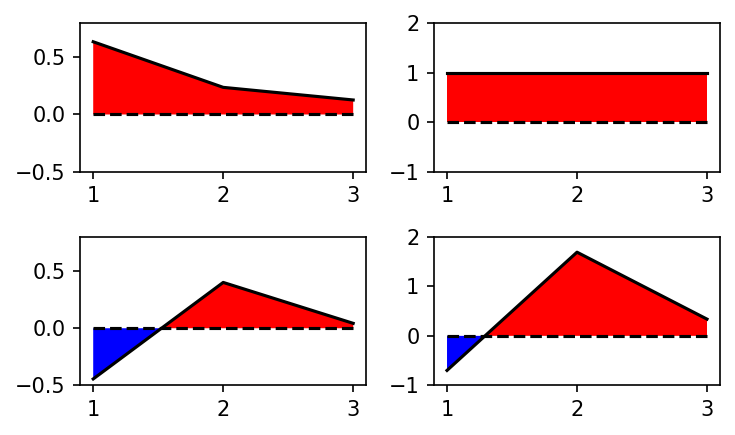

In [20]:
def plot_eigenvector(ax, eig):
    '''Plot eigenvector.'''
    x = np.arange(1, len(eig) + 1, 1)
    y = eig
    ax.plot(x, y, color='k')
    ax.plot(x, [0]*len(x), '--', color='k')
    ax.fill_between(x, 0, y, where= y>=0, facecolor='red', interpolate=True)
    ax.fill_between(x, 0, y, where= y<=0, facecolor='blue', interpolate=True)

fig, axs = plt.subplots(2, 2)
plot_eigenvector(axs[0][0], MSM.eigenvectors_left()[0])
plot_eigenvector(axs[1][0], MSM.eigenvectors_left()[1])
plot_eigenvector(axs[0][1], MSM.eigenvectors_right()[:, 0])
plot_eigenvector(axs[1][1], MSM.eigenvectors_right()[:, 1])

for ax in axs[:, 0]:
    ax.set_ylim(-0.5, 0.8)
for ax in axs[:, 1]:
    ax.set_ylim(-1, 2)

for ax in axs.flat:
    ax.set_xticks(np.arange(1, 4, 1))
plt.tight_layout()

## Open-Close Transition

In [21]:
ete_data = []
for i in range(1, 4):
    x = d_ete_traj[:, 0][np.where(clustering.to_dtrajs()[0] == i, True, False)]
    ete_data.append(x)

/home/lwehrhan/anaconda3/envs/algosb/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


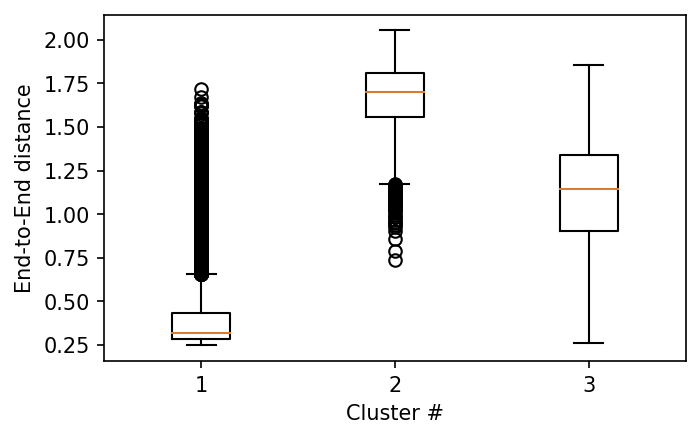

In [46]:
fig, ax = plt.subplots()
ax.boxplot(ete_data)
ax.set_ylabel('End-to-End distance')
ax.set_xlabel('Cluster #')
plt.show()

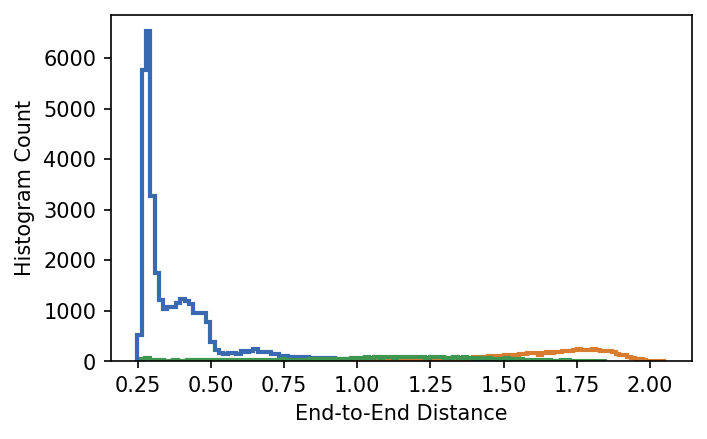

In [44]:
fig, ax = plt.subplots()
ax.hist(ete_data[0], histtype='step', linewidth=2, bins=100)
ax.hist(ete_data[1], histtype='step', linewidth=2, bins=100)
ax.hist(ete_data[2], histtype='step', linewidth=2, bins=100)
ax.set_xlabel('End-to-End Distance')
ax.set_ylabel('Histogram Count')
plt.show()

## Markov State Model on End-to-End Distance

In [25]:
d = md.compute_distances(t[1000::10], [[0, 75]])


d_min = np.amin(d)
d_max = np.amax(d) + 0.01
d_range = d_max - d_min

n_states = 100
delta_d = d_range / n_states

d_discretized = np.floor((d - d_min) / delta_d).astype('int')
d_discretized = d_discretized[:, 0]

C = np.zeros((n_states,n_states))
tau = 100

for x in range(len(d_discretized) - tau):
    state_i = d_discretized[x]
    state_j = d_discretized[x + tau]
    C[state_i, state_j] += 1

C_db = C + np.transpose(C)

T = np.zeros((n_states, n_states))
for i in range(n_states):
    T[i, :] = C[i, :] / np.sum(C[i, :])
    
eig_right = np.real(np.linalg.eig(T)[1])
eig_left = np.real(np.linalg.eig(T.T)[1])

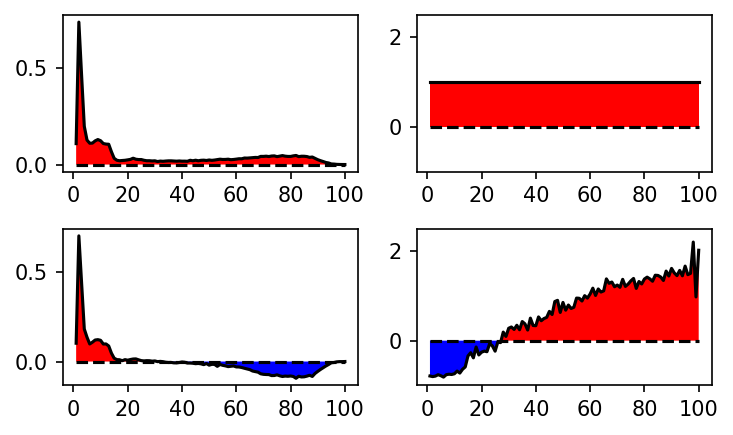

In [26]:
fig, axs = plt.subplots(2, 2)
plot_eigenvector(axs[0][0], eig_left[:, 0])
plot_eigenvector(axs[1][0], eig_left[:, 1] * -1)
plot_eigenvector(axs[0][1], eig_right[:, 0] * 10)
plot_eigenvector(axs[1][1], eig_right[:, 1] * 10)

for ax in axs[:, 1]:
    ax.set_ylim(-1, 2.5)
    
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 101, 20))
plt.tight_layout()